# Neural Networks with code

This file will build on a previous one to code a Neural Network with one hidden layer and a one-node output layer for classification. The code is based on exercises from the Deep Learning Specialization from **DeepLearning.ai**.

First, let's load and take a look at the data:

Shape of X: (2, 400)
Shape of Y: (1, 400)


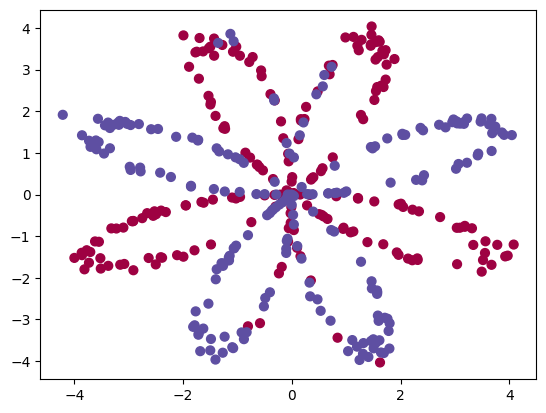

In [5]:
import csv
import numpy as np

# Note: this data pattern was taken from an exercise in the specialisation 
# "Deep Learning Specialization" from DeepLearning.ai

# file path
csv_file_path = 'data/nn_data.csv'

# Initialize empty lists to store data
X = []
Y = []

# Read data from the CSV file
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.DictReader(csvfile)

    # Extract data from each row
    for row in csv_reader:
        X.append([float(row['X1']), float(row['X2'])])
        Y.append(float(row['Y']))

# Convert lists to numpy arrays
X = np.array(X).T  # Transpose to have shape (2, 400)
Y = np.array([Y])  # shape (1, 400)

# Print the shapes of X and Y to verify
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# View the data:
import matplotlib.pyplot as plt
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

We see that there are 2 classes (blue and red dots) in the data with a pattern that would be impossible to classify with a logistic regression.

Let's separate the data into training and testing sets, but without using sklearn's library this time:

In [6]:
import random

# Let's validate that input and labelled output have the same size
assert X.shape[1] == Y.shape[1]

# Now, we'll create a list with the same number of elements in the data set and randomly shuffle it
# notice that shuffling the elements is important in case there is some pattern we aren't aware of
i = [_ for _ in range(X.shape[1])]
random.shuffle(i)

# Calculate an index to split the data set into 95%/05%
split_index = int(len(i)*0.95)

i_train = i[:split_index]
i_test = i[split_index:]

# Split the training and test sets accordingly
X_train = X[:, i_train]
X_test = X[:, i_test]

Y_train = Y[:, i_train]
Y_test = Y[:, i_test]

We'll use the **sigmoid function** to activate the neurons on the output layer, so we need to code it. Notice the use of the numpy version for the exponential instead of the math version, this is done given that the math version works with scalars while the numpy version can work with arrays, which allows us to use vectors instead of for-loops in the calculations.

Let's remember that the sigmoid function is used to generate non-linear responses in a neuron and returns a value that goes between 0 and 1:

$\quad \sigma (z) = \frac{1}{1+e^{-z}}$

Where *z* is typically a linear function of the activation for the previous neuron:

$\quad z_{(w,b)}(a^{[i]}) = W•a^{[i]} + b $

Where $a^{[0]}= X$ (the input vector) and $a^{[i]}$ is the activation function for the neurons in layer i.

In [7]:
def sigmoid(z):
    """ 
    Argument: matrix or vector that will have the form z = W•a_i + b 
    (a_i will be the input data when i=0 or the activation vector for i>0)

    Returns: Activation vector 1/(1+exp(-z))
    """
    
    # it's important to use np.exp instead of math.exp since the latter doesn't work with vectors
    a = 1 / (1+np.exp(-z)) 

    return a

Now, let's code the a function to define random initial variables for the model's patameters. Notice that we have 1 hidden layer, so we'll have 4 parameters:

$\quad$ **Layer (hidden) 1**:

- **W1**: will be the weights vector connecting the input X and the neurons in the hidden layer. Notice that this vector with be shaped (n_h,n_x), where n_x: number of features in the data set and n_h: number of neurons in the layer (in this case 4).
- **b1**: represents the bias for the equations between the input layer and the hidden layer. This will be a single scalar value, but repeated n_h (4) times to allow vectorial calculations with W1.

$\quad$ **Output Layer**:
- **W2**: is the weights vector connecting the hidden layer to the output layer. This vector will be shaped (n_y, n_h), where n_h: number of neurons in the hidden layer, and n_y: number of neurons in the output layer.
- **b2**: represents the bias for the equations between the hidden layer and the output layer. This will be a single scalar value, but repeated n_y times to allow vectorial calculations with W2.

(*Notice that initialising the weights to values different than zero is neccesary to start the gradient descent without being 'stuck' with the same parameters.*)

In [8]:
import random
def initialise_parameters(n_x, n_h, n_y):
    """
    Arguments:
        n_x: size of the input layer
        n_h: number of neurons in hidden layer
        n_y: number of neurons in output layer

    Outputs:
    parameters: we'll use a dictionary to deliver the values more easily
        W1: weights matrix shaped (n_h,n_x)
        b1: bias vector shaped (n_h,1)
        W2: weights matrix shaped (n_y,n_h)
        b2: biase vector shaped (n_y,1)
    """
    W1 = np.random.rand(n_h, n_x)/100
    b1 = np.zeros((n_h,1))

    W2 = np.random.rand(n_y,n_h)/100
    b2 = np.zeros((n_y,1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2
                  }

    return parameters

Now, let's prepare the **forward propagation function** considering 1 hidden layer. For this pattern we need to use an hyperbolic tangent activation function for the hidden layer (the sigmoid was tried without satisfactory results).

$\quad tanh(z) = g(z) = tanh(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}}$

$\quad g'(z) = \frac{dg(z)}{dz} = 1 - tanh(z)^2$

In [9]:
def fwd_prop(X, parameters):
    """
    Arguments:
        X: input data shaped (n_x, m), where n_x: number of features and m: number of samples
        parameters: dictionary containing the weights W1, b1, W2, b2
    Returns:
        A2: output layer activation values
        nn_data: contains the Z values and activation values for layer 1
    """

    # Unpack parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    # Let's calculate the activation values A1 and A2 for layers 1 (hidden) and 2 (output)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    assert(A2.shape == (1,X.shape[1]))

    # let's pack-up the activation data for the layers
    nn_data = {"Z1": Z1,
               "A1": A1,
               "Z2": Z2,
               "A2": A2}
    
    return nn_data

Remember that the **Loss Function** for a classifier is:

$$ Loss\_function(a^{[2]}) = - \small y^{(i)}\log\left(a^{[2] (i)}\right) - (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) $$

And the **Cost Function** becomes:

$$J(a^{[2]}) = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} $$


With this, we calculate the **Cost Function** with the output of the model (A2) and the labelled output from the data (Y):



In [10]:
def cost_fnct(A2,Y):
    """
    Arguments:
        A2: Output of the model
        Y: Labelled output in data
    
    Returns:
        cost: float value with the Cost for a classifier model    
    """
    m = Y.shape[1] # number of samples

    logs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), (1-Y))
    cost = - np.sum(logs) / m 

    cost = float(np.squeeze(cost)) # makes sure we return 17 instead of [[17]]

    return cost

Now we'll calculate the **back propagation**. 

If we use the sigmoid activation function for the output layer, we know that:

$ \quad \frac{\delta{J}}{\delta{w^{[2]}}} = \frac{1}{m} a^{[1]} (a^{[2]} - y)$, and

$ \quad \frac{\delta{J}}{\delta{b^{[2]}}} = \frac{1}{m} (a^{[2]} - y)$

We are also using the tanh(z) activation for the hidden layer, so we have:

$ \quad \frac{\delta{J}}{\delta{w^{[1]}}} = \frac{1}{m} (a^{[2]} - y) w^{[2]} (1 - tanh^2(z)) a^{[0]}$, with $a^{[0]} = X$

In [11]:
def back_prop(parameters, nn_data, X, Y):
    """
    Arguments:
    nn_data: contains activation values
    X: input data set
    Y: labelled output data set
    
    Returns:
    gradients: dictionary with gradients dj_dw1, dj_db1, dj_dw2, dj_db2 
    """
    
    # define number of samples to calculate averages
    m = X.shape[1] 

    # load activation values
    A2 = nn_data["A2"]
    A1 = nn_data["A1"]

    W2 = parameters["W2"]
    
    # calculate the partial derivatives for layer 2 (terminal layer)
    dz2 = A2 - Y
    dj_dw2 = np.dot(dz2, A1.T)/m
    dj_db2 = np.sum(dz2, axis=1, keepdims=True)/m

    # calculate the partial derivatives for layer 1 (hidden layer)
    dz1 = np.dot(W2.T, dz2)*(1-np.power(A1,2))
    dj_dw1 = np.dot(dz1, X.T)/m
    dj_db1 = np.sum(dz1, axis=1, keepdims=True)/m

    # create the output dic
    gradients = {"dj_dw1": dj_dw1, 
                 "dj_db1": dj_db1, 
                 "dj_dw2": dj_dw2, 
                 "dj_db2": dj_db2
                 }
    
    return gradients

Now, we need a function to update the parameters W and b:

In [12]:
import copy
def update_parameters(parameters, gradients, learn_rate = 0.001):

    # load current parameters
    W1 = copy.deepcopy(parameters["W1"])
    b1 = parameters["b1"]
    W2 = copy.deepcopy(parameters["W2"])
    b2 = parameters["b2"]

    # load gradientes
    dw1 = gradients["dj_dw1"]
    db1 = gradients["dj_db1"]
    dw2 = gradients["dj_dw2"]
    db2 = gradients["dj_db2"]

    # update parameters
    W1 = W1 - learn_rate*dw1
    b1 = b1 - learn_rate*db1
    W2 = W2 - learn_rate*dw2
    b2 = b2 - learn_rate*db2

    # create output dic
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

And now, we'll create a function to integrate the previous ones into one model:

In [26]:
def fit(X,Y, n_h=4, num_iterations=100000):

    # define model structure
    np.random.seed(3)
    n_x = X.shape[0]    # remember that X.shape = (n,m) with n: features and m: samples
    n_y = Y.shape[0]    # number of neurons in the output layer Y.shape = n_y, m
    n_h = n_h

    # set initial value for parameters
    parameters = initialise_parameters(n_x, n_h, n_y)

    # now we iterate to find the optimal parameters
    for i in range(0, num_iterations):
        nn_data = fwd_prop(X, parameters)
        grads = back_prop(parameters, nn_data, X, Y)
        parameters = update_parameters(parameters,grads)

        if i % 10000 == 0:
            print("Cost after iteration %i: %f" %(i, cost_fnct(nn_data["A2"], Y)) )

    return parameters

In [27]:
# Let's fit the model
optimal_parameters = fit(X_train,Y_train)

Cost after iteration 0: 0.693154
Cost after iteration 10000: 0.692923
Cost after iteration 20000: 0.687535
Cost after iteration 30000: 0.678309
Cost after iteration 40000: 0.672569
Cost after iteration 50000: 0.654499
Cost after iteration 60000: 0.632043
Cost after iteration 70000: 0.619581
Cost after iteration 80000: 0.608812
Cost after iteration 90000: 0.559627


In [28]:
# This code was taken from the Deep Learning Specialisation examples
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

Let's plot the regions defined by the model:

[[0.39187457 0.39443022 0.39701057 ... 0.62760947 0.63011438 0.63259355]]


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

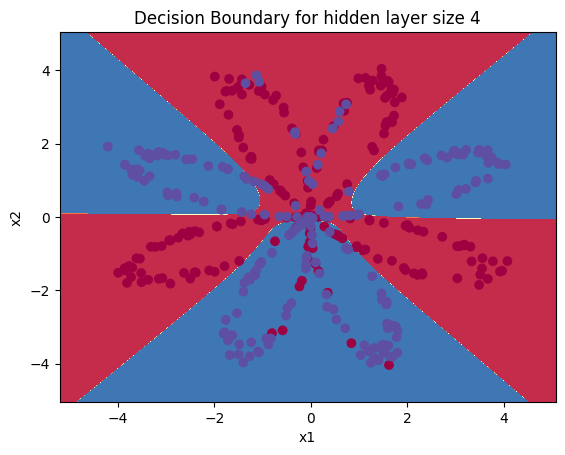

In [30]:
plot_decision_boundary(lambda x: predict(optimal_parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

### Prediction

Now, let's code a prediction function that returns $\hat{y}=1$ when the output $a^{[2]}>0.5$ and 0 otherwise.

In [29]:
def predict(parameters, X):
    """
    Argument:
        Parameters: optimal values for W and b
        X: input data

    Returns:
        Y: Predictions for the output (red:0 | blue: 1)
    """

    # Determine the output value for the new input X
    nn_data = fwd_prop(X, parameters)
    A2 = nn_data['A2']

    print(A2)

    # assign 1 or 0 according to output and threshold
    prediction = (A2 > 0.5).astype(int)

    return prediction

Finally, let's compare the prediction with the actual Y_test values:

In [31]:
y_hat_test = predict(optimal_parameters, X_test)

[[0.54920158 0.42393662 0.21611218 0.746748   0.46289301 0.23729096
  0.27431383 0.59453496 0.22842915 0.26627891 0.64832935 0.74811218
  0.58267549 0.47383326 0.78052349 0.47988455 0.518939   0.21613524
  0.782504   0.27695995]]


In [32]:
# Evaluate the test results
true_pos = np.sum((Y_test == 1) & (y_hat_test == 1))
false_pos = np.sum((Y_test == 0) & (y_hat_test == 1))
false_neg = np.sum((Y_test == 1) & (y_hat_test == 0))

prec = true_pos / (true_pos + false_pos)
rec = true_pos / (true_pos + false_neg)

# analysis of performance
print(f"Precision: {prec:.2f}\nRecall: {rec:.2f}")
print(f"Accuracy in the test set: {np.sum((Y_test==y_hat_test))/len(Y_test[0]):.2f}")

Precision: 0.89
Recall: 0.89
Accuracy in the test set: 0.90
